In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd 
import skimage.morphology as sk
from operator import itemgetter

In [2]:
# PARAMETERS
N_DIST_COEFF_PRELIM = 0.7
DIM_MIN = 0.5
DIM_MAX = 2
AREA_MIN = 0.5
AREA_MAX = 2
N_DIST_COEFF = 0.9
BIN_PRECISION_FACTOR = 0.25 #ottimizzato 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.2
NEIGH = 1
NUM_EPOCHS = 2
T_Q = 5 #5
T_M = 0 #1/25
THRESHOLD_Q = 200 #ottimizzato 200
THRESHOLD_M = 1/3
COLOR_T = 50
CONSISTENCY_COEFF = 0.5

In [3]:
def compute_all_keypoints():

    image_dict = {}

    for img in query_imgs:
        file = 'models/'+img+'.jpg'
        query = cv2.imread(file,0)
        kp, des = sift.detectAndCompute(query,None)
        image_dict[img] = {'kp': kp,'des': des,'shape': query.shape}

    for img in train_imgs:
        file = 'scenes/'+img+'.png'
        train = cv2.imread(file,0)
        kp, des = sift.detectAndCompute(train,None)
        image_dict[img] = {'kp': kp,'des': des, 'shape': train.shape}

    return image_dict

In [4]:
def apply_ratio_test(all_matches,coeff):

    good_matches = {}      #map of matches kp_train_idx -> kp_query_idx
    
    for m,n in all_matches:
        if m.distance < coeff*n.distance:
            good_matches[m.queryIdx]= m.trainIdx


    return good_matches

In [5]:
def compute_entry_hough_space(kp_q,kp_t,q_xc,q_yc):

    entry = {}

    v = ((q_xc-kp_q.pt[0]), (q_yc-kp_q.pt[1]))
    scale_ratio = kp_t.size/kp_q.size
    delta_angle = kp_t.angle-kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c']= x_c
    entry['y_c']= y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle
   

    return entry 

In [6]:
def create_hough_space(good_matches,kp_query,kp_train,query_xc,query_yc):
    
    hough_space = {}     #map of hough space kp_train_idx -> map name-values

    for t_idx,q_idx in good_matches.items():
        hough_space[t_idx] = compute_entry_hough_space(kp_query[q_idx],kp_train[t_idx],query_xc,query_yc)
    
    return hough_space

In [7]:
def compute_bins(hough_space,query_shape,train_shape):

    values = {}
    
    data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
    counts_scale, bins_scale, patches_size = plt.hist(data_scale,bins='auto')
    img_scale = np.mean([bins_scale[np.argmax(counts_scale)],bins_scale[np.argmax(counts_scale)+1]])
    plt.close();

    data_angle = [entry['delta_angle'] for entry in hough_space.values()]
    counts_angle, bins_angle, patches_angle = plt.hist(data_angle,bins='auto')
    plt.close();

    x_bin_size = img_scale * query_shape[1] * BIN_PRECISION_FACTOR
    y_bin_size = img_scale * query_shape[0] * BIN_PRECISION_FACTOR
    x_bins = int(np.ceil(train_shape[1]/x_bin_size)+2)
    y_bins = int(np.ceil(train_shape[0]/y_bin_size)+2)
    x_min = train_shape[1]/2 - x_bins/2 * x_bin_size
    y_min = train_shape[0]/2 - y_bins/2 * y_bin_size

    angle_bin_size = np.std(data_angle)*ANGLE_BIN_SIZE_COEFF
    angle_bin_center = np.mean(data_angle)
    angle_min = angle_bin_center - ANGLE_BINS/2 * angle_bin_size
    angle_max = angle_bin_center + ANGLE_BINS/2 * angle_bin_size

    scale_bin_size = np.std(data_scale)*SCALE_BIN_SIZE_COEFF
    scale_bin_center = np.mean(data_scale)
    scale_min = 0 
    scale_max = scale_bin_center * 2 
    scale_bins = int((scale_max-scale_min)/scale_bin_size)

    values['x_bins'] = x_bins
    values['y_bins'] = y_bins
    values['x_min'] = x_min
    values['y_min'] = y_min
    values['x_bin_size'] = x_bin_size
    values['y_bin_size'] = y_bin_size
    values['scale_bins'] = scale_bins
    values['scale_min'] = scale_min
    values['scale_bin_size'] = scale_bin_size
    values['angle_min'] = angle_min
    values['angle_bin_size'] = angle_bin_size 

    return values

In [8]:
def voting(b,h_s):

    accumulator = np.zeros((b['x_bins'],b['y_bins'],ANGLE_BINS,b['scale_bins']))

    votes = {}

    for idx,v in h_s.items():
        try:
            for x in range(0,2):
                for y in range(0,2):
                    for z in range(0,2):
                        for w in range(0,2):                
                            i = int(np.floor((v['x_c']-b['x_min']+(x-1/2)*b['x_bin_size'])/b['x_bin_size']))
                            j = int(np.floor((v['y_c']-b['y_min']+(y-1/2)*b['y_bin_size'])/b['y_bin_size']))
                            k = int(np.floor((v['delta_angle']-b['angle_min']+(z-1/2)*b['angle_bin_size'])/b['angle_bin_size']))
                            l = int(np.floor((v['scale_ratio']-b['scale_min']+(w-1/2)*b['scale_bin_size'])/b['scale_bin_size']))
                            if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                                accumulator[i][j][k][l]+=1
                                votes[(i,j,k,l)] = votes.get((i,j,k,l),[])
                                votes[(i,j,k,l)].append(idx)
        except: pass
    
    return accumulator,votes

    

In [9]:
query_imgs = ['0','1','11','19','24','25','26']
train_imgs = ['e1','e2','e3','e4','e5','m1','m2','m3','m4','m5']

In [10]:
def step_B(query_imgs, train_img, image_dict):

    global_correspondences = []
    recognised = {}

    for query_img in query_imgs:

        kp_query, des_query = image_dict[query_img]['kp'], image_dict[query_img]['des']
        kp_train, des_train = image_dict[train_img]['kp'], image_dict[train_img]['des']

        all_matches = bf.knnMatch(des_train, des_query, k=2)

        if image_dict[query_img]['shape'][0] >= 200:
            N_DIST_COEFF = 0.9
        if image_dict[query_img]['shape'][0] >= 400:
            N_DIST_COEFF = 0.8
        if image_dict[query_img]['shape'][0] >= 600:
            N_DIST_COEFF = 0.7

        #map of matching keypoint indexes
        good_matches = apply_ratio_test(all_matches, N_DIST_COEFF)

        #barycenter of found query keypoint 
        query_xc = np.mean(list(kp_query[i].pt[0] for i in range(len(kp_query))))
        query_yc = np.mean(list(kp_query[i].pt[1] for i in range(len(kp_query))))

        #create hough space 
        hough_space = create_hough_space(good_matches,kp_query,kp_train,query_xc,query_yc)

        #compute all the values related to the size 
        bins_values = compute_bins(hough_space,image_dict[query_img]['shape'],image_dict[train_img]['shape'])

        #create and populate accumulator with voting by each entry of the hough space 
        accumulator,votes= voting(bins_values,hough_space)

        #compute local maxima of the 4d accumulator 
        mask=sk.local_maxima(accumulator)
        accumulator[mask!=1] = 0

        #store in a list all the correspondeces between query points and train points that voted for a local maxima 
            #the list contain: number of votes that a local maxima bin has received, name of query                                                                                                   image, list of query and train keypoints which voted for that bin 

        T = T_Q+int(image_dict[query_img]['shape'][0]*T_M)               #threhsold to come up with few maxima 

        for b in list(np.argwhere(accumulator>=T)):
            keypoint_index_list = votes[tuple(b)]       #all query keypoint who voted for a local maxima bin 
            correspondence_list = [(kp_train[k],kp_query[good_matches[k]]) for k in keypoint_index_list]
            global_correspondences.append([accumulator[tuple(b)],query_img,correspondence_list])

    g_c = sorted(global_correspondences, key=itemgetter(0), reverse=True )    #sorted correspondences based on number of votes found in local maxima bins 

    
    train_file = 'scenes/' + train_img + '.png'
    train = cv2.imread(train_file, 0)              
    train_rgb = cv2.cvtColor(train, cv2.COLOR_GRAY2RGB)
    train_bgr = cv2.imread(train_file)

    areas = []

    #qui ci va un commento 
    for entry in g_c:
        try:
 
            query_file = 'models/'+entry[1]+'.jpg'
            query_bgr = cv2.imread(query_file)
            
            src_pts = np.float32([e[1].pt for e in entry[2]]).reshape(-1, 1, 2)
            dst_pts = np.float32([e[0].pt for e in entry[2]]).reshape(-1, 1, 2)
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w, d = query_bgr.shape
            pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)
        
            # center = tuple((dst[0,0,i] + dst[1,0,i] + dst[2,0,i] + dst[3,0,i]) / 4 for i in (0,1))
                                  
            x_min = int(max((dst[0,0,0] + dst[1,0,0]) / 2, 0))
            y_min = int(max((dst[0,0,1] + dst[3,0,1]) / 2, 0))
            x_max = int(min((dst[2,0,0] + dst[3,0,0]) / 2, train_bgr.shape[1]))
            y_max = int(min((dst[1,0,1] + dst[2,0,1]) / 2, train_bgr.shape[0]))


            for _ in range(NUM_EPOCHS):
            
                dst_pts2 = []
                src_pts2 = []

                for i in range(len(src_pts)):
                    if dst_pts[i][0][0] > x_min and dst_pts[i][0][0] < x_max\
                    and dst_pts[i][0][1] > y_min and dst_pts[i][0][1] < y_max:
                        dst_pts2.append([dst_pts[i][0][0],dst_pts[i][0][1]])
                        src_pts2.append([src_pts[i][0][0],src_pts[i][0][1]])

                src_pts = np.float32(src_pts2).reshape(-1,1,2)
                dst_pts = np.float32(dst_pts2).reshape(-1,1,2)

            dst = cv2.perspectiveTransform(pts, M)
        
            center = tuple((dst[0,0,i] + dst[1,0,i] + dst[2,0,i] + dst[3,0,i]) / 4 for i in (0,1))
                                  
            x_min = int(max((dst[0,0,0] + dst[1,0,0]) / 2, 0))
            y_min = int(max((dst[0,0,1] + dst[3,0,1]) / 2, 0))
            x_max = int(min((dst[2,0,0] + dst[3,0,0]) / 2, train_bgr.shape[1]))
            y_max = int(min((dst[1,0,1] + dst[2,0,1]) / 2, train_bgr.shape[0]))



            query_color = query_bgr.mean(axis=0).mean(axis=0)
            train_crop = train_bgr[y_min:y_max,x_min:x_max]
            train_color = train_crop.mean(axis=0).mean(axis=0)   
            color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))
        

            area = 0
            for i in range(3):
                area += dst[i][0][0]*dst[i+1][0][1]-dst[i+1][0][0]*dst[i][0][1]
            area += dst[3][0][0]*dst[0][0][1]-dst[0][0][0]*dst[3][0][1]
            area = abs(area/2)
            areas.append(area)

            temp = True 
            if color_diff < COLOR_T and area/areas[0] > AREA_MIN and area/areas[0] < AREA_MAX\
                and dst[0][0][0] < dst[3][0][0]\
                and dst[1][0][0] < dst[2][0][0]\
                and dst[0][0][1] < dst[1][0][1]\
                and dst[3][0][1] < dst[2][0][1]:
                for k, v in recognised.items():
                    for corners in v:
                        if center[0] > corners[0,0,0] and center[0] < corners[3,0,0]\
                            and center[1] > corners[0,0,1] and center[1] < corners[1,0,1]:
                            temp = False
                            break
                if temp:
                    recognised[entry[1]] = recognised.get(entry[1],[])  
                    recognised[entry[1]].append(dst)
        except: pass


    for k, v in recognised.items():
        for dst in v:
            
            train_rgb = cv2.polylines(train_rgb, [np.int32(dst)], True, (0,255,0), 3, cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(train_rgb, k,\
                            #(int((v[3][0][0] - v[00,0]) * 0.25 + v[0,0,0]),int((v[1,0,1] - v[0,0,1]) * 0.67 + v[0,0,1])),\
                            #font, 5, (0,255,0), 10, cv2.LINE_AA)        
            
        
    plt.imshow(train_rgb),plt.show();
    print('\n')

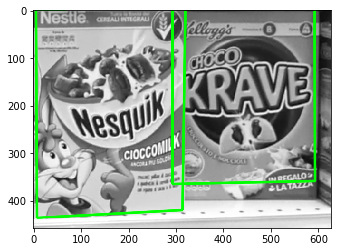

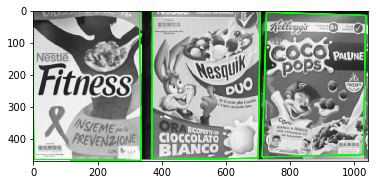

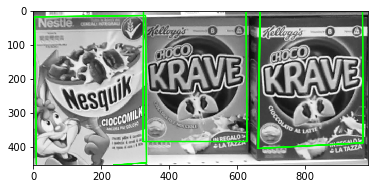

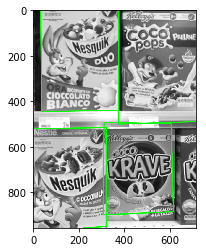

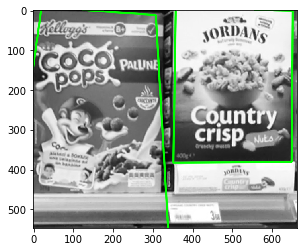

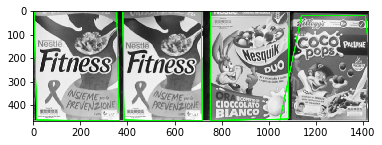

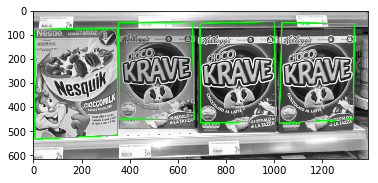

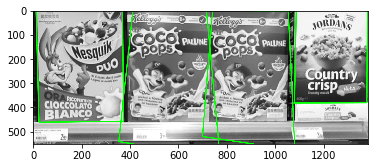

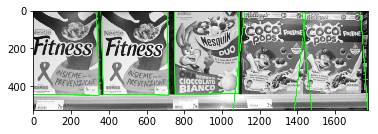

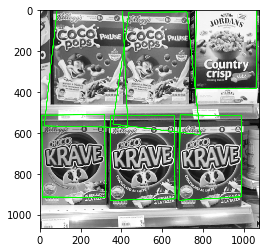

In [11]:
sift = cv2.xfeatures2d.SIFT_create()

bf = cv2.BFMatcher()

image_dict = compute_all_keypoints()

for train_img in train_imgs:

    step_B(query_imgs, train_img,image_dict)
        

In [12]:
# areas = []
#     dimensions = []
#     delta = []
#     centers = []
#     for j in range(len(g_c)):
#         try:
#             train2 = cv2.cvtColor(train,cv2.COLOR_GRAY2RGB)
#             matches = g_c[j]
#             better_c = g_c[j]
#             file = 'models/'+matches[1]+'.jpg'
#             query = cv2.imread(file,0)
#             query2 = cv2.imread(file)
#             query_color = query2.mean(axis=0).mean(axis=0)
#             src_pts = np.float32([ m[1].pt for m in matches[2] ]).reshape(-1,1,2)
#             dst_pts = np.float32([ m[0].pt for m in matches[2] ]).reshape(-1,1,2)
#             M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#             matchesMask = mask.ravel().tolist()
#             h,w = query.shape
#             pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#             dst = cv2.perspectiveTransform(pts,M)
# #            print(np.float32(list(global_centers[matches[0]])).reshape(-1,1,2))
#             #new_center = cv2.perspectiveTransform(np.float32(list(global_centers[matches[0]])).reshape(-1,1,2),M)[0][0]
#             x_minimum = int(max(np.min(dst,axis=0)[0][0],0))
#             y_minimum = int(max(np.min(dst,axis=0)[0][1],0))
#             x_maximum = int(min(np.max(dst,axis=0)[0][0],train.shape[1]))
#             y_maximum = int(min(np.max(dst,axis=0)[0][1],train.shape[0]))

            
#             for ijk in range(NUM_EPOCHS):
            
#                 dst_pts2 = []
#                 src_pts2 = []

#     #            print(dst_pts)

#                 for i in range(len(src_pts)):
#                     if dst_pts[i][0][0] > x_minimum and dst_pts[i][0][0] < x_maximum\
#                     and dst_pts[i][0][1] > y_minimum and dst_pts[i][0][1] < y_maximum:
#                         dst_pts2.append([dst_pts[i][0][0],dst_pts[i][0][1]])
#                         src_pts2.append([src_pts[i][0][0],src_pts[i][0][1]])

#     #            print(dst_pts2)

#                 src_pts = np.float32(src_pts2).reshape(-1,1,2)
#                 dst_pts = np.float32(dst_pts2).reshape(-1,1,2)
            
            
#             M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#             matchesMask = mask.ravel().tolist()
#             h,w = query.shape
#             pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
#             dst = cv2.perspectiveTransform(pts,M)
# #            print(np.float32(list(global_centers[matches[0]])).reshape(-1,1,2))
#             #new_center = cv2.perspectiveTransform(np.float32(list(global_centers[matches[0]])).reshape(-1,1,2),M)[0][0]
#             x_minimum = int(max(np.min(dst,axis=0)[0][0],0))
#             y_minimum = int(max(np.min(dst,axis=0)[0][1],0))
#             x_maximum = int(min(np.max(dst,axis=0)[0][0],train.shape[1]))
#             y_maximum = int(min(np.max(dst,axis=0)[0][1],train.shape[0]))
            
#             dimensions.append(((x_maximum-x_minimum),(y_maximum-y_minimum)))
#             delta.append(np.sqrt((x_minimum-x_maximum)**2+(y_minimum-y_maximum)**2))
#             center = (int((x_maximum+x_minimum)/2),int((y_maximum+y_minimum)/2))
#             train_crop = train[y_minimum:y_maximum,x_minimum:x_maximum]
#             train_color = train_crop.mean(axis=0).mean(axis=0)
#             draw_params = dict(matchColor = (0,0,0), # draw matches in green color
#                            singlePointColor = None,
#                            matchesMask = matchesMask, # draw only inliers
#                            flags = 2)
#             color_diff = abs(query_color-train_color)
#             dist = []
#             area = 0
#             for i in range(3):
#                 area += dst[i][0][0]*dst[i+1][0][1]-dst[i+1][0][0]*dst[i][0][1]
#             area += dst[3][0][0]*dst[0][0][1]-dst[0][0][0]*dst[3][0][1]
#             area = abs(area/2)
#             areas.append(area)
#             for c in centers:
#                 dist.append(np.sqrt((center[0]-c[0])**2+(center[1]-c[1])**2))
#             min_dist = float("inf")
#             if len(dist)>0:
#                 min_dist = min(dist)
# #                print(min_dist)
#             if max(color_diff)<COLOR_T and min_dist > delta[0]*CONSISTENCY_COEFF\
#                 and area/areas[0] > AREA_MIN and area/areas[0] < AREA_MAX\
#                 and (x_maximum-x_minimum)/dimensions[0][0] > DIM_MIN and (x_maximum-x_minimum)/dimensions[0][0] < DIM_MAX\
#                 and (y_maximum-y_minimum)/dimensions[0][1] > DIM_MIN and (y_maximum-y_minimum)/dimensions[0][1] < DIM_MAX\
#                 and dst[0][0][0] < dst[3][0][0]\
#                 and dst[1][0][0] < dst[2][0][0]\
#                 and dst[0][0][1] < dst[1][0][1]\
#                 and dst[3][0][1] < dst[2][0][1]:
#                 train2 = cv2.polylines(train2,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)
#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 cv2.putText(train2, matches[1],\
#                         (int((x_maximum-x_minimum)/4+x_minimum),int((y_maximum-y_minimum)*0.67+y_minimum)),\
#                         font, 5, (0,127,255), 10, cv2.LINE_AA)
                
#                 centers.append(center)
#                 plt.imshow(train2),plt.show();
#         except: pass
# #    plt.figure(figsize = (15,10))
# ##    plt.imshow(train2),plt.show();
